<a href="https://colab.research.google.com/github/cwattsnogueira/rating-predictor-spam-detection-review-summarizer/blob/main/10_01_ml_modeling_FakeR_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Core packages
import pandas as pd
import numpy as np
import joblib

# Modeling & evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# SMOTE
from imblearn.over_sampling import SMOTE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_parquet("/content/engineered_features.parquet")
structured_features = joblib.load("/content/feature_names.json")

X = df[structured_features]
y = df['fake_review_label']

print("Original class distribution:\n", y.value_counts())

Original class distribution:
 fake_review_label
0    8800
1     680
Name: count, dtype: int64


In [ ]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

print("After SMOTE:\n", pd.Series(y_smote).value_counts())

After SMOTE:
 fake_review_label
1    8800
0    8800
Name: count, dtype: int64


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_smote, y_smote, train_size=0.6, stratify=y_smote, random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, train_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape, "Validation:", X_val.shape)

Train: (10560, 18) Test: (3520, 18) Validation: (3520, 18)


In [ ]:
def train_and_evaluate(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n Evaluation: {name}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC Curve — {name}")
    plt.show()

    return model


 Evaluation: Logistic Regression (SMOTE)
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1760
           1       0.98      0.98      0.98      1760

    accuracy                           0.98      3520
   macro avg       0.98      0.98      0.98      3520
weighted avg       0.98      0.98      0.98      3520

Confusion Matrix:
[[1719   41]
 [  37 1723]]
AUC-ROC: 0.9970


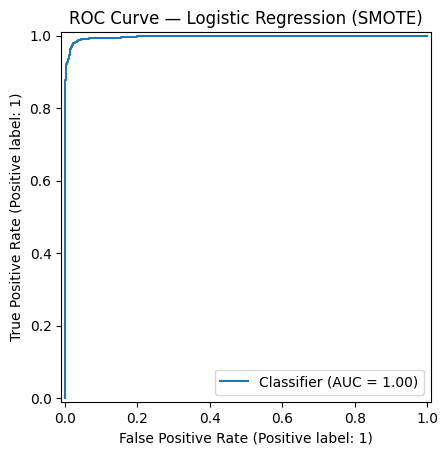

In [ ]:
lr_smote = train_and_evaluate(LogisticRegression(max_iter=1000), "Logistic Regression (SMOTE)")


 Evaluation: Random Forest (SMOTE)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1760
           1       1.00      1.00      1.00      1760

    accuracy                           1.00      3520
   macro avg       1.00      1.00      1.00      3520
weighted avg       1.00      1.00      1.00      3520

Confusion Matrix:
[[1755    5]
 [   7 1753]]
AUC-ROC: 1.0000


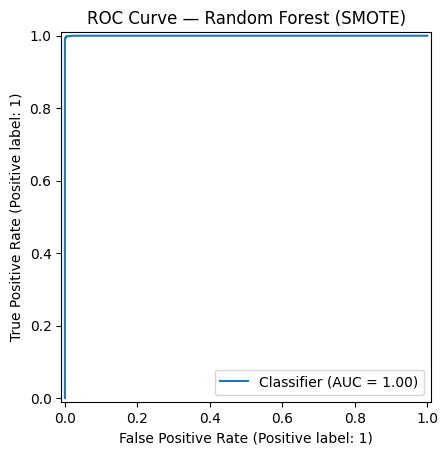

In [ ]:
rf_smote = train_and_evaluate(RandomForestClassifier(n_estimators=100), "Random Forest (SMOTE)")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:33:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Evaluation: XGBoost (SMOTE)
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1760
           1       0.99      1.00      1.00      1760

    accuracy                           1.00      3520
   macro avg       1.00      1.00      1.00      3520
weighted avg       1.00      1.00      1.00      3520

Confusion Matrix:
[[1750   10]
 [   6 1754]]
AUC-ROC: 0.9999


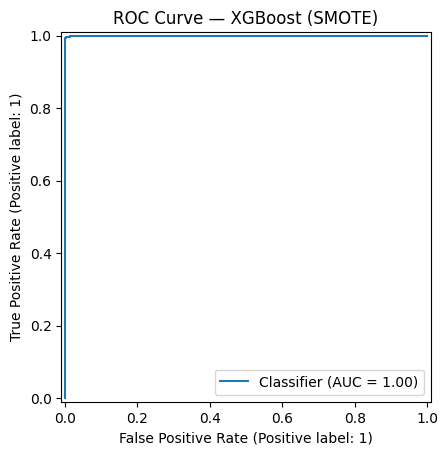

In [ ]:
xgb_smote = train_and_evaluate(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), "XGBoost (SMOTE)")

In [ ]:
def evaluate_on_validation(model, name):
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]

    print(f"\n Validation: {name}")
    print(classification_report(y_val, y_val_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_val_pred))
    print(f"AUC-ROC: {roc_auc_score(y_val, y_val_proba):.4f}")

In [ ]:
evaluate_on_validation(xgb_smote, "XGBoost (SMOTE)")


 Validation: XGBoost (SMOTE)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1760
           1       1.00      1.00      1.00      1760

    accuracy                           1.00      3520
   macro avg       1.00      1.00      1.00      3520
weighted avg       1.00      1.00      1.00      3520

Confusion Matrix:
[[1756    4]
 [   4 1756]]
AUC-ROC: 1.0000


In [ ]:
joblib.dump(xgb_smote, "/content/ml_model_smote.pkl")
print("Saved model as ml_model_smote.pkl")

Saved model as ml_model_smote.pkl


In [ ]:
models = {
    "LogReg (SMOTE)": lr_smote,
    "RF (SMOTE)": rf_smote,
    "XGB (SMOTE)": xgb_smote
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_proba)
    f1 = classification_report(y_val, y_pred, output_dict=True)['weighted avg']['f1-score']
    results.append((name, round(auc, 4), round(f1, 4)))

comparison_df = pd.DataFrame(results, columns=["Model", "AUC-ROC", "F1 Score"])
comparison_df.sort_values(by="AUC-ROC", ascending=False)

,Model,AUC-ROC,F1 Score
1,RF (SMOTE),1.0000,0.9974
2,XGB (SMOTE),1.0000,0.9977
0,LogReg (SMOTE),0.9969,0.9807
